<a href="https://colab.research.google.com/github/vijishmadhavan/Crop-CLIP/blob/master/Crop_CLIP_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install requirements
%%capture
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install ipyplot
! pip install pytube
! pip install av
! pip install ipyplot


In [2]:
video_url = 'https://www.youtube.com/watch?v=6XMuUVw7TOM'

In [3]:
#@title Download video

from pytube import YouTube

streams = YouTube(video_url).streams.filter(adaptive=True, subtype="mp4", resolution="360p", only_video=True)
streams[0].download(filename="video.mp4")

import av

keyframes = []
content = 'video.mp4'
with av.open(content) as container:
    stream = container.streams.video[0]
    stream.codec_context.skip_frame = 'NONKEY'

    for frame in container.decode(stream):
        img_pil = frame.to_image()
        keyframes.append(img_pil)


illegal short term buffer state detected
illegal short term buffer state detected
 (repeated 6 more times)


In [30]:
search_query = "Man in suit"


In [31]:
#@title import requirements

import torch
import clip
from PIL import Image

import glob
import clip
import numpy as np
import requests
from PIL import Image
import io

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

images = torch.stack([preprocess(im) for im in keyframes]).to(device)
with torch.no_grad():
  image_features = model.encode_image(images)
  image_features /= image_features.norm(dim=-1, keepdim=True)

image_features.cpu().numpy()
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

images = [preprocess(im) for im in keyframes]
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
image_features /= image_features.norm(dim=-1, keepdim=True)

def top(similarity_list,N):
  results = zip(range(len(similarity_list)), similarity_list)
  results = sorted(results, key=lambda x: x[1],reverse= True)
  top_images = []
  scores=[]
  for index,score in results[:N]:
    scores.append(score)
    top_images.append(keyframes[index])
  return scores,top_images




In [32]:
#@title Enocde Text

import ipyplot

with torch.no_grad():
    # Encode and normalize the description using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)


similarity = text_encoded.cpu().numpy() @ image_features.cpu().numpy().T
similarity = similarity[0]
scores,img= top(similarity,N=1)


In [33]:
#@title Yolo

import sys
import warnings
import tempfile
from io import BytesIO

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

results = model(img[0])  # includes NMS
#image_path = "/content/"
#os.mkdir(image_path)
#image = results.save("/content/image")
dirpath = tempfile.mkdtemp()
results.crop(save_dir=dirpath)
from IPython.display import Image
#Image(filename='/content/image/image0.jpg')
path= dirpath+'/crops/**/*.jpg'


from PIL import Image

l = []
#keyList = list(range(len(txtfiles)))
for filename in glob.glob(path):
  foo = Image.open(filename).convert('RGB')
  #resized_image = foo.resize((250,250))
  l.append(foo) 

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2022-1-4 torch 1.10.0+cu111 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

Fusing layers... 



requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Saved 1 image to /tmp/tmpabkrml69
Saved results to /tmp/tmpabkrml69



In [34]:
#@title Encode Images

import torch
import glob
import clip
import numpy as np
import requests
from PIL import Image
import io


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = torch.stack([preprocess(im) for im in l]).to(device)

with torch.no_grad():
  image_features = model.encode_image(image)
  image_features /= image_features.norm(dim=-1, keepdim=True)

image_features.cpu().numpy()
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

image = [preprocess(im) for im in l]
image_input = torch.tensor(np.stack(image)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
image_features /= image_features.norm(dim=-1, keepdim=True)

def similarity_top(similarity_list,N):
  results = zip(range(len(similarity_list)), similarity_list)
  results = sorted(results, key=lambda x: x[1],reverse= True)
  top_images = []
  scores=[]
  for index,score in results[:N]:
    scores.append(score)
    top_images.append(l[index])
  return scores,top_images


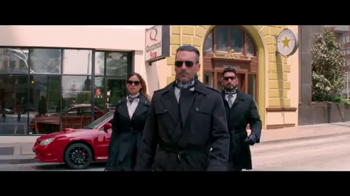


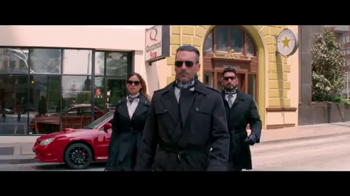


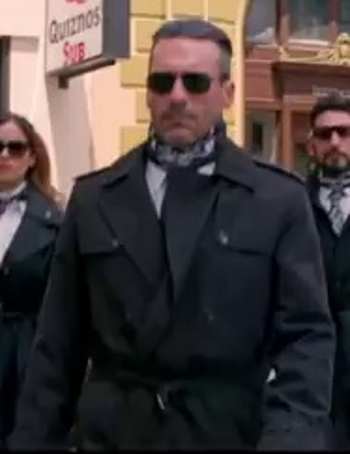


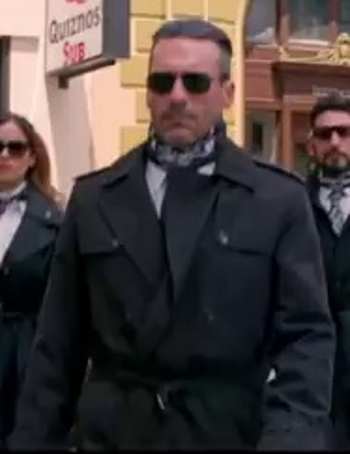

In [35]:
#@title Search result 
similarity = text_encoded.cpu().numpy() @ image_features.cpu().numpy().T
similarity = similarity[0]
scores,imgs= similarity_top(similarity,N=1)
ipyplot.plot_images(img,img_width=350)
ipyplot.plot_images(imgs,img_width=350)